In [5]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from torchvision.ops import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

# from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

import datetime

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

In [6]:
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]

def load_module():
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('../output', demonet,
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    net = resnetv1(num_layers=101)
    net.create_architecture(21, tag='default', anchor_scales=[8, 16, 32])
    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)

    return net

In [7]:
def _append_coords(scores, boxes, categories, x_offset=0):
    result = dict()
    for category in categories:
        idx_boxes = boxes[:, 4*category:4*(category + 1)]
        idx_scores = scores[:, category]
        clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
        valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
        valid_boxes = idx_boxes[valid_idxs]
        
        result[category] = np.vstack((
            (x_offset + (valid_boxes[:, 0] + valid_boxes[:, 2]) / 2),
            (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T
    return result

In [8]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_coords(net, file_path, categories):
    im = cv2.imread(file_path)
    
    mid_x = im.shape[1]//2
    
    output = dict()
    for img, offset_x in zip((im[:, :mid_x], im[:, mid_x:]), (0, mid_x)):
        result = _append_coords(*im_detect(net, img), categories, offset_x)
        
        for k, v in result.items():
            if k not in output:
                output[k] = v
            else:
                output[k] = np.concatenate((output[k], v))
    return output

In [9]:
IMAGE_H = 512
IMAGE_W = 1392

src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst = np.float32([[246, IMAGE_H], [IMAGE_W-246, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

def transform_coords(coords):
    coords = np.pad(coords, ((0, 0), (0, 1)), mode="constant", constant_values=1)
    transformed = np.dot(M, coords.T)
    return transformed[:2] / transformed[-1]

In [10]:
def show_image(im_path):
    im = cv2.imread(im_path)
    
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.imshow(im, aspect='equal')
    
    plt.axis('off')
    plt.tight_layout()
    
    plt.draw()

In [11]:
def draw_points(coords):
    fig, ax = plt.subplots(figsize=(24, 24), facecolor="black")
    ax.set(xlim=(0, IMAGE_W), ylim=(IMAGE_H, 0), aspect='equal')    
    
    for category, coord in coords.items():
        marker, size = ('d', 80) if category == 7 else ('o', 40)
        ax.scatter(*transform_coords(coord), marker=marker, s=size*20, c="white")
        
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [12]:
net = load_module()

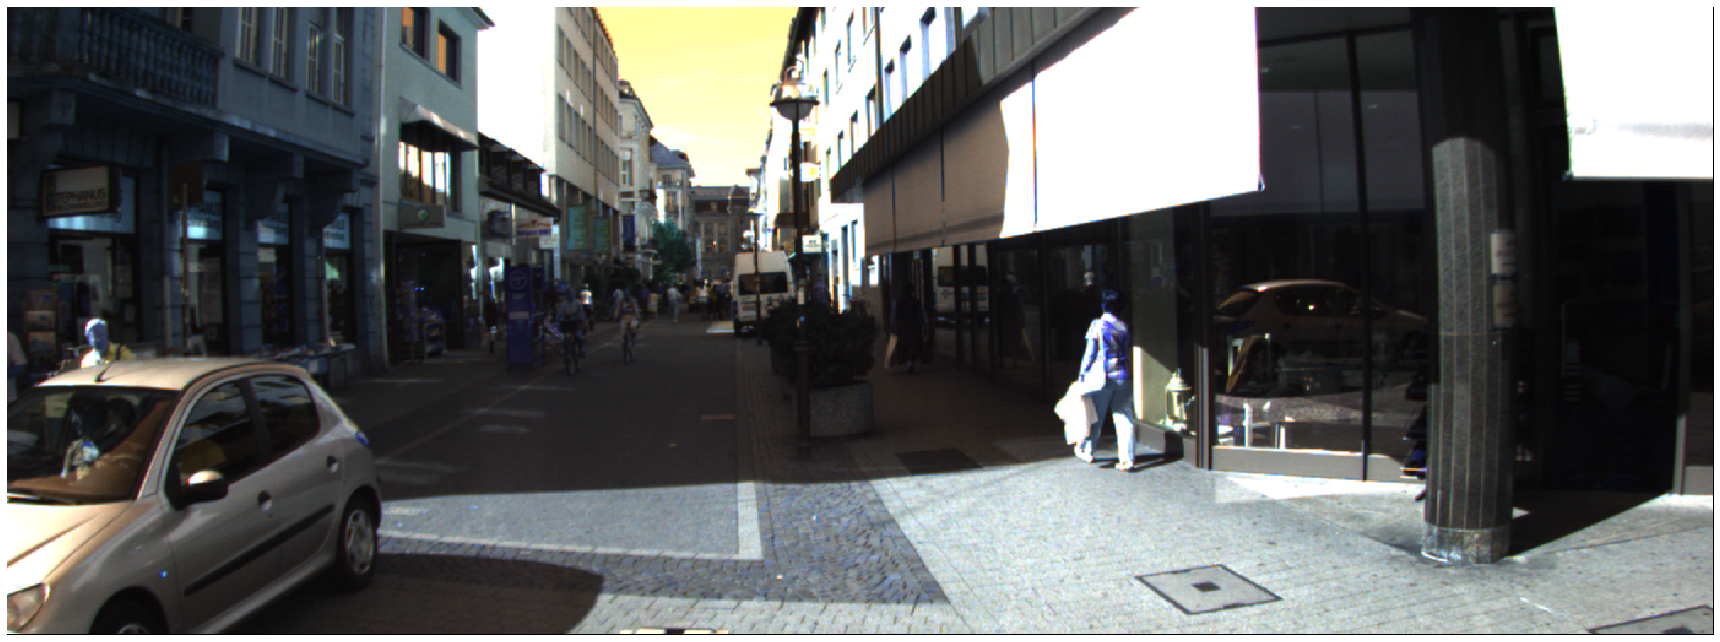

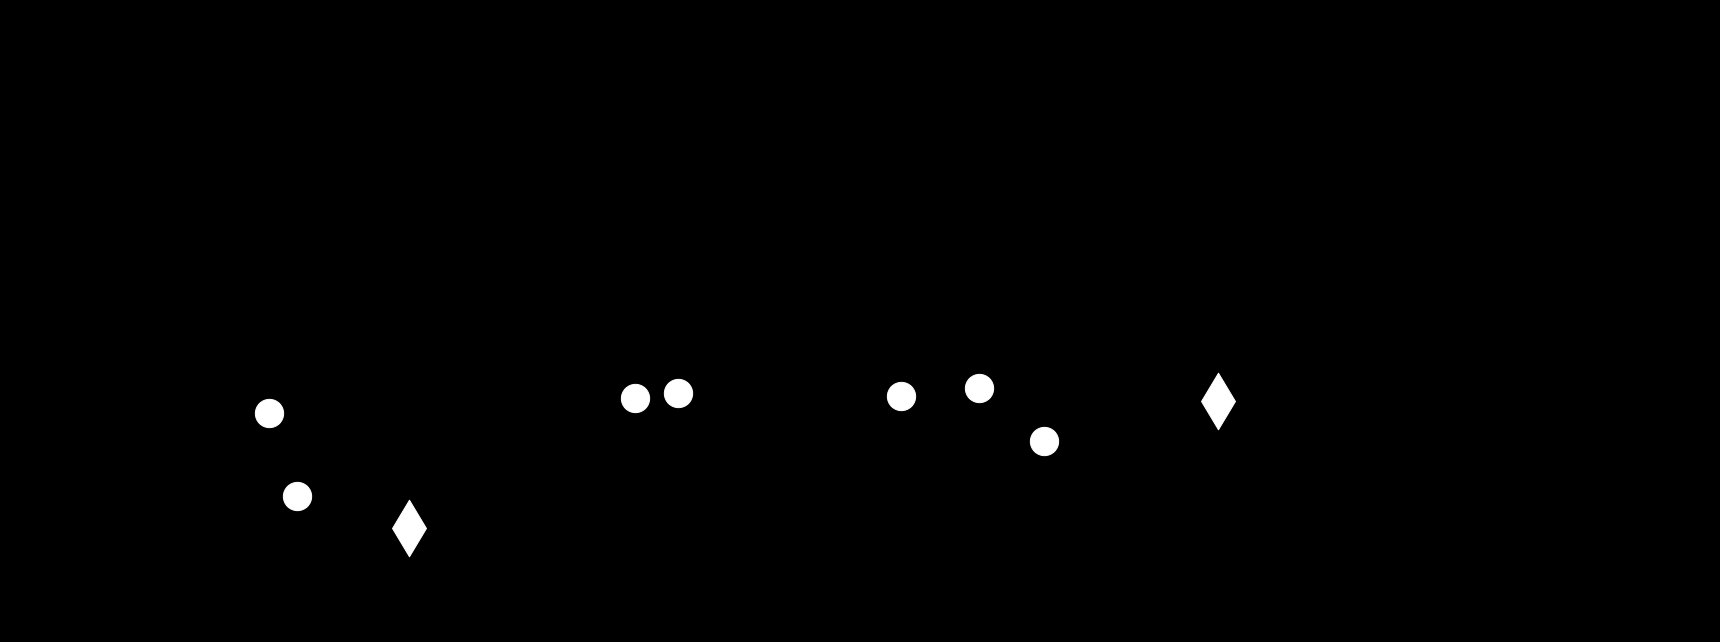

In [13]:
img_name = "../data/demo/0000000000.png"

show_image(img_name)

target_classes = [7, 15]
output = get_coords(net, img_name, target_classes)
draw_points(output)